# Import Relevant Libraries

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
import numpy as np
from torchvision import transforms
import time
from zipfile import ZipFile
from glob import glob
from torchvision.models import vgg19

# Download Dataset

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"haikalardikatama","key":"70cedbbde60ce92be6a791826285560c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 99% 1.17G/1.17G [00:33<00:00, 54.8MB/s]
100% 1.17G/1.17G [00:34<00:00, 36.9MB/s]


# Extract and Explore the Data

In [ ]:
!ls

kaggle.json  labeled-chest-xray-images.zip  sample_data


In [ ]:
zip_ref = ZipFile('/content/labeled-chest-xray-images.zip', 'r')
zip_ref.extractall('/content/dataset')
zip_ref.close()

In [ ]:
train_dir = '/content/dataset/chest_xray/train'
test_dir = '/content/dataset/chest_xray/test'

In [ ]:
train_pneumonia_dir = glob(train_dir+'/PNEUMONIA/*.jpeg')
train_normal_dir = glob(train_dir+'/NORMAL/*.jpeg')

In [ ]:
print(f'Banyak data latih pneumonia :{len(train_pneumonia_dir)}')
print(f'Banyak data latih normal :{len(train_normal_dir)}')

Banyak data latih pneumonia :3883
Banyak data latih normal :1349


In [ ]:
test_pneumonia_dir = glob(test_dir+'/PNEUMONIA/*.jpeg')
test_normal_dir = glob(test_dir+'/NORMAL/*.jpeg')

In [ ]:
print(f'Banyak data test pneumonia :{len(test_pneumonia_dir)}')
print(f'Banyak data test normal :{len(test_normal_dir)}')

Banyak data test pneumonia :390
Banyak data test normal :234


In [ ]:
pneumonia = np.asarray(plt.imread(train_pneumonia_dir[0]))
normal = np.asarray(plt.imread(train_normal_dir[0]))

Image size :(1056, 1448)


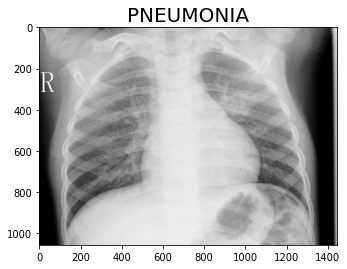

In [ ]:
plt.title('PNEUMONIA', fontsize=20, color='black')
plt.imshow(pneumonia, cmap='gray')
print(f'Image size :{pneumonia.shape}')

Image size: (1430, 1712)


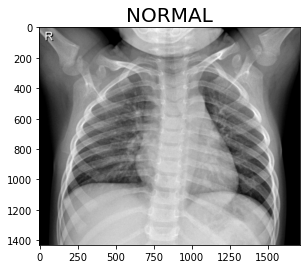

In [ ]:
plt.title('NORMAL', fontsize=20, color='black')
plt.imshow(normal, cmap='gray')
print(f'Image size: {normal.shape}')

# Transform and Load Image

In [ ]:
img_size =(256, 256)

train_val_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
dataset = ImageFolder(train_dir, 
                      transform= train_val_transform)
test_set = ImageFolder(test_dir, transform=test_transform)
img,  label = dataset[0]
print(img.shape, label)

torch.Size([3, 256, 256]) 0


In [ ]:
labels = dataset.classes
labels

['NORMAL', 'PNEUMONIA']

In [ ]:
# Split into train and val dataset
random_seed = 42
torch.manual_seed(random_seed);

val_size = int(len(dataset) * 0.25)
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_data_size = len(train_ds)
valid_data_size = len(val_ds)
test_data_size = len(test_set)

# Data Loader

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

# Create Model

In [ ]:
vgg_model = vgg19(pretrained=True)

for param in vgg_model.parameters():
  print(param)
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Parameter containing:
tensor([[[[-5.3474e-02, -4.9257e-02, -6.7942e-02],
          [ 1.5314e-02,  4.5068e-02,  2.1444e-03],
          [ 3.6226e-02,  1.9999e-02,  1.9864e-02]],

         [[ 1.7015e-02,  5.5403e-02, -6.2293e-03],
          [ 1.4165e-01,  2.2705e-01,  1.3758e-01],
          [ 1.2000e-01,  2.0030e-01,  9.2114e-02]],

         [[-4.4885e-02,  1.2680e-02, -1.4497e-02],
          [ 5.9742e-02,  1.3955e-01,  5.4102e-02],
          [-9.6141e-04,  5.8304e-02, -2.9663e-02]]],


        [[[ 2.6072e-01, -3.0489e-01, -5.0152e-01],
          [ 4.1376e-01, -2.0831e-01, -4.9086e-01],
          [ 5.8770e-01,  4.2851e-01, -1.3850e-01]],

         [[ 2.8746e-01, -3.3338e-01, -4.5564e-01],
          [ 3.7836e-01, -2.9144e-01, -4.9720e-01],
          [ 5.4778e-01,  4.8983e-01, -1.7166e-01]],

         [[ 6.7260e-02, -9.5386e-02, -3.8037e-02],
          [ 6.1955e-02, -1.3125e-01, -1.0691e-01],
          [ 4.8107e-02,  2.2999e-01, -3.0578e-02]]],


        [[[-3.2457e-02,  1.6281e-01,  5.9687

In [ ]:
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
class PneumoniaNet(nn.Module):
  
  def __init__(self, output_size):
    super().__init__()
    self.vgg19 = vgg19(pretrained=True)
    self.freeze_layer()
    self.vgg19.classifier = nn.Sequential(
    nn.Linear(25088, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(inplace=False),
    nn.Linear(4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, out_features=output_size),
    # nn.Softmax()
    )
  
  def forward(self, x):
    x = self.vgg19(x)
    return x

  def freeze_layer(self):
    for param in self.vgg19.parameters():
      param.requires_grad = False
  
  def unfreeze_layer(self):
    for param in self.vgg19.parameters():
      param.requires_grad = True


In [ ]:
model = PneumoniaNet(len(labels))

In [ ]:
model

PneumoniaNet(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

# Training Model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model = model.to(device)

In [ ]:
def train_and_validate(model, loss_criterion, optimizer, train_data_loader, valid_data_loader, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

        
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss - {:.4f}, Accuracy - {:.4f}%, \n\t\tValidation : Loss - {:.4f}, Accuracy - {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model,'pneumonia_model_'+str(epoch)+'.pt')
            
    return model, history, best_epoch

In [ ]:
num_epochs = 10
# Define Optimizer and Loss Function
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
trained_model, history, best_epoch = train_and_validate(model, loss_func, optimizer, train_dl, val_dl , num_epochs)



Epoch: 1/10


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Batch number: 000, Training: Loss: 0.6886, Accuracy: 0.5312
Batch number: 001, Training: Loss: 29.6573, Accuracy: 0.7734
Batch number: 002, Training: Loss: 1.4184, Accuracy: 0.5469
Batch number: 003, Training: Loss: 0.2058, Accuracy: 0.9141
Batch number: 004, Training: Loss: 0.2447, Accuracy: 0.9297
Batch number: 005, Training: Loss: 0.2258, Accuracy: 0.9219
Batch number: 006, Training: Loss: 0.2037, Accuracy: 0.9375
Batch number: 007, Training: Loss: 0.1351, Accuracy: 0.9375
Batch number: 008, Training: Loss: 0.2418, Accuracy: 0.8984
Batch number: 009, Training: Loss: 0.1917, Accuracy: 0.9141
Batch number: 010, Training: Loss: 0.1333, Accuracy: 0.9688
Batch number: 011, Training: Loss: 0.1263, Accuracy: 0.9531
Batch number: 012, Training: Loss: 0.1998, Accuracy: 0.9375
Batch number: 013, Training: Loss: 0.1528, Accuracy: 0.9453
Batch number: 014, Training: Loss: 0.2031, Accuracy: 0.9219
Batch number: 015, Training: Loss: 0.1082, Accuracy: 0.9609
Batch number: 016, Training: Loss: 0.22

In [ ]:
history

[[1.1756168415240191,
  0.07689378993864818,
  0.9102956161100444,
  0.9686544342507645],
 [0.07426473107967416,
  0.06310490928932068,
  0.9734964316044379,
  0.9740061162079511],
 [0.05087924107033892,
  0.0897095844901483,
  0.9808868501529052,
  0.9663608566336676],
 [0.038066584058675565,
  0.051380768509450676,
  0.9849643218164901,
  0.9824159025052271],
 [0.039448705867358186,
  0.048742727629999864,
  0.985474006116208,
  0.9831804281345565],
 [0.02008987368520247,
  0.08752380155983867,
  0.9920998977594054,
  0.9717125382262997],
 [0.019234560272456066,
  0.04979779316676319,
  0.9931192657512505,
  0.9839449541284404],
 [0.015589689759482515,
  0.06544430462489707,
  0.995158002038736,
  0.9824159021406728],
 [0.034659242593549446,
  0.089854683692849,
  0.9875127414923074,
  0.9808868505174596],
 [0.025595035479915738,
  0.07742364221716738,
  0.9915902140672783,
  0.9785932721712538]]

In [ ]:
torch.save(history, 'history.pt')

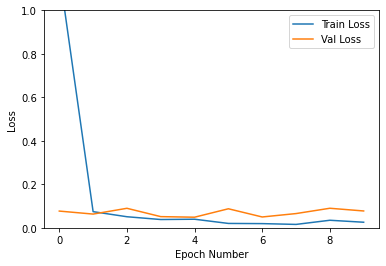

In [ ]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Train Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig('pneumonia_loss_curve.png')
plt.show()

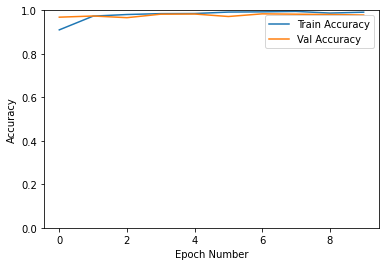

In [ ]:
plt.plot(history[:,2:4])
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig('pneumonia_accuracy_curve.png')
plt.show()

# Test Model

In [ ]:
def computeTestSetAcc(model, test_dl, loss_criterion):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  test_acc = 0.0
  test_loss = 0.0

  # Validation - No gradient
  with torch.no_grad():
    # Eval Phase
    model.eval()
    for j,(inputs, labels) in enumerate(test_dl):
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Forward
      outputs = model(inputs)

      # Compute loss
      loss = loss_criterion(outputs, labels)

      # Compute total loss
      test_loss += loss.item() * inputs.size(0)

      ret, predictions = torch.max(outputs.data, 1)
      correct_counts = predictions.eq(labels.data.view_as(predictions))

      acc = torch.mean(correct_counts.type(torch.FloatTensor))
      test_acc += acc.item() * inputs.size(0)
      print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
  avg_test_loss = test_loss/test_data_size 
  avg_test_acc = test_acc/test_data_size

  print("Test accuracy : " + str(avg_test_acc))

In [ ]:
test_dl = DataLoader(test_set, 32, num_workers=2, pin_memory=True)
computeTestSetAcc(model,test_dl, loss_func)

Test Batch number: 000, Test: Loss: 3.7888, Accuracy: 0.4375
Test Batch number: 001, Test: Loss: 3.8293, Accuracy: 0.5625
Test Batch number: 002, Test: Loss: 2.4872, Accuracy: 0.4688
Test Batch number: 003, Test: Loss: 3.0905, Accuracy: 0.5625
Test Batch number: 004, Test: Loss: 3.0527, Accuracy: 0.6562
Test Batch number: 005, Test: Loss: 3.4599, Accuracy: 0.4688
Test Batch number: 006, Test: Loss: 3.7094, Accuracy: 0.4688
Test Batch number: 007, Test: Loss: 0.5636, Accuracy: 0.8750
Test Batch number: 008, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 009, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 010, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 011, Test: Loss: 0.2060, Accuracy: 0.9688
Test Batch number: 012, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 013, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 014, Test: Loss: 0.0001, Accuracy: 1.0000
Test Batch number: 015, Test: Loss: 0.0000, Accuracy: 1.0000
Test Batch number: 016, 

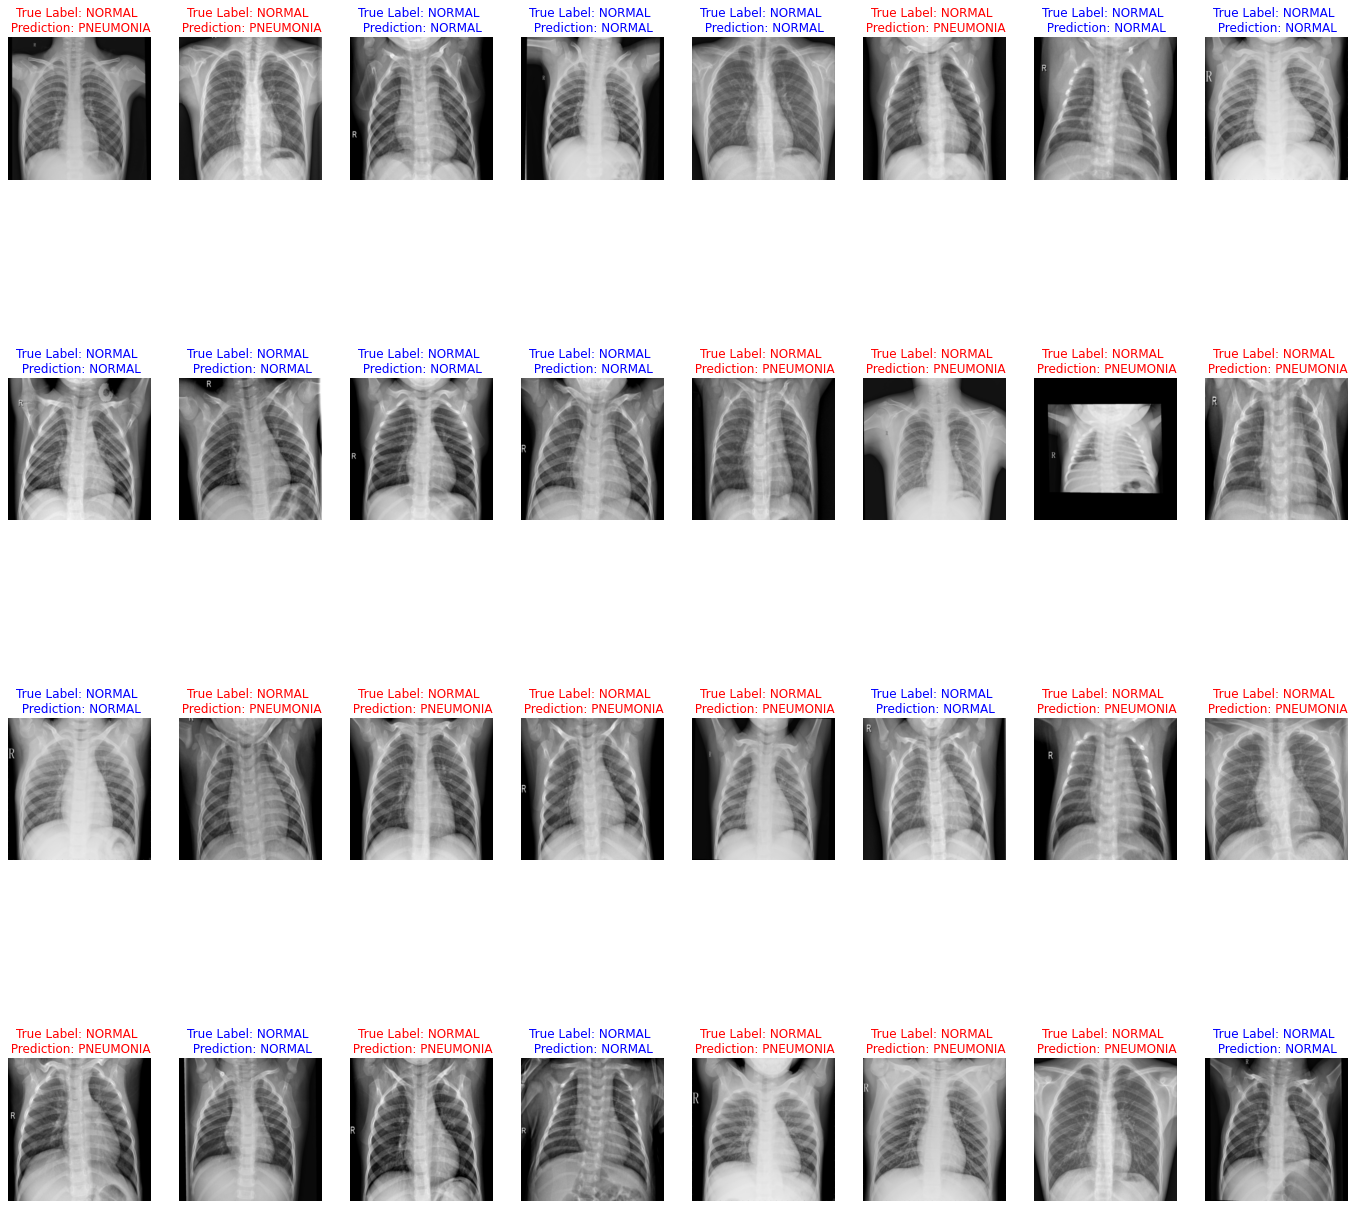

In [ ]:
def inverse_norm(img):
  img[0, :, :] = img[0, :, :] * 0.229 + 0.485
  img[1, :, :] = img[1, :, :] * 0.224 + 0.456
  img[2, :, :] = img[2, :, :] * 0.225 + 0.406
  return img

def predict_and_visualize(model, test_dl, classes):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  inputs, labels = next(iter(test_dl))
  inputs, labels = inputs.to(device), labels.to(device)
  with torch.no_grad():
    model.eval()
    output = model(inputs)
    preds = output.argmax(1)

  fig, axes = plt.subplots(4, 8, figsize=(24, 24))
  for img, label, pred, ax in zip(inputs, labels, preds, axes.flatten()):
    ax.imshow(inverse_norm(img).permute(1, 2, 0).cpu())
    font = {"color": 'r'} if label != pred else {"color": 'b'}
    label, pred = classes[label.item()], classes[pred.item()]
    ax.set_title(f"True Label: {label} \n Prediction: {pred}", fontdict=font);
    ax.axis('off');

predict_and_visualize(model, test_dl, labels)

# Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

new_test_dl = DataLoader(test_set, batch_size=512, shuffle=True)

for data in new_test_dl:
  input, label = data

In [ ]:
input = input.to(device)
with torch.no_grad():
  model.eval()
  output = model(input)
  preds = output.argmax(1)

In [ ]:
label = label.to('cpu')
preds = preds.to('cpu')
print(classification_report(label, preds, target_names=labels))

              precision    recall  f1-score   support

      NORMAL       1.00      0.63      0.77        43
   PNEUMONIA       0.81      1.00      0.90        69

    accuracy                           0.86       112
   macro avg       0.91      0.81      0.83       112
weighted avg       0.88      0.86      0.85       112



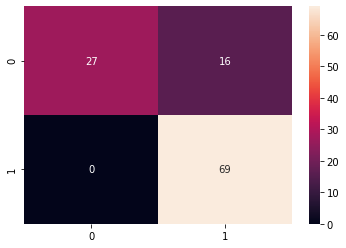

In [ ]:
cf_matrix = confusion_matrix(label, preds)
sns.heatmap(cf_matrix, annot=True)

# Pick the Best Model and Evaluate the Model

In [ ]:
best_model = torch.load('/content/pneumonia_model_4.pt')
best_model

PneumoniaNet(
  (vgg19): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (

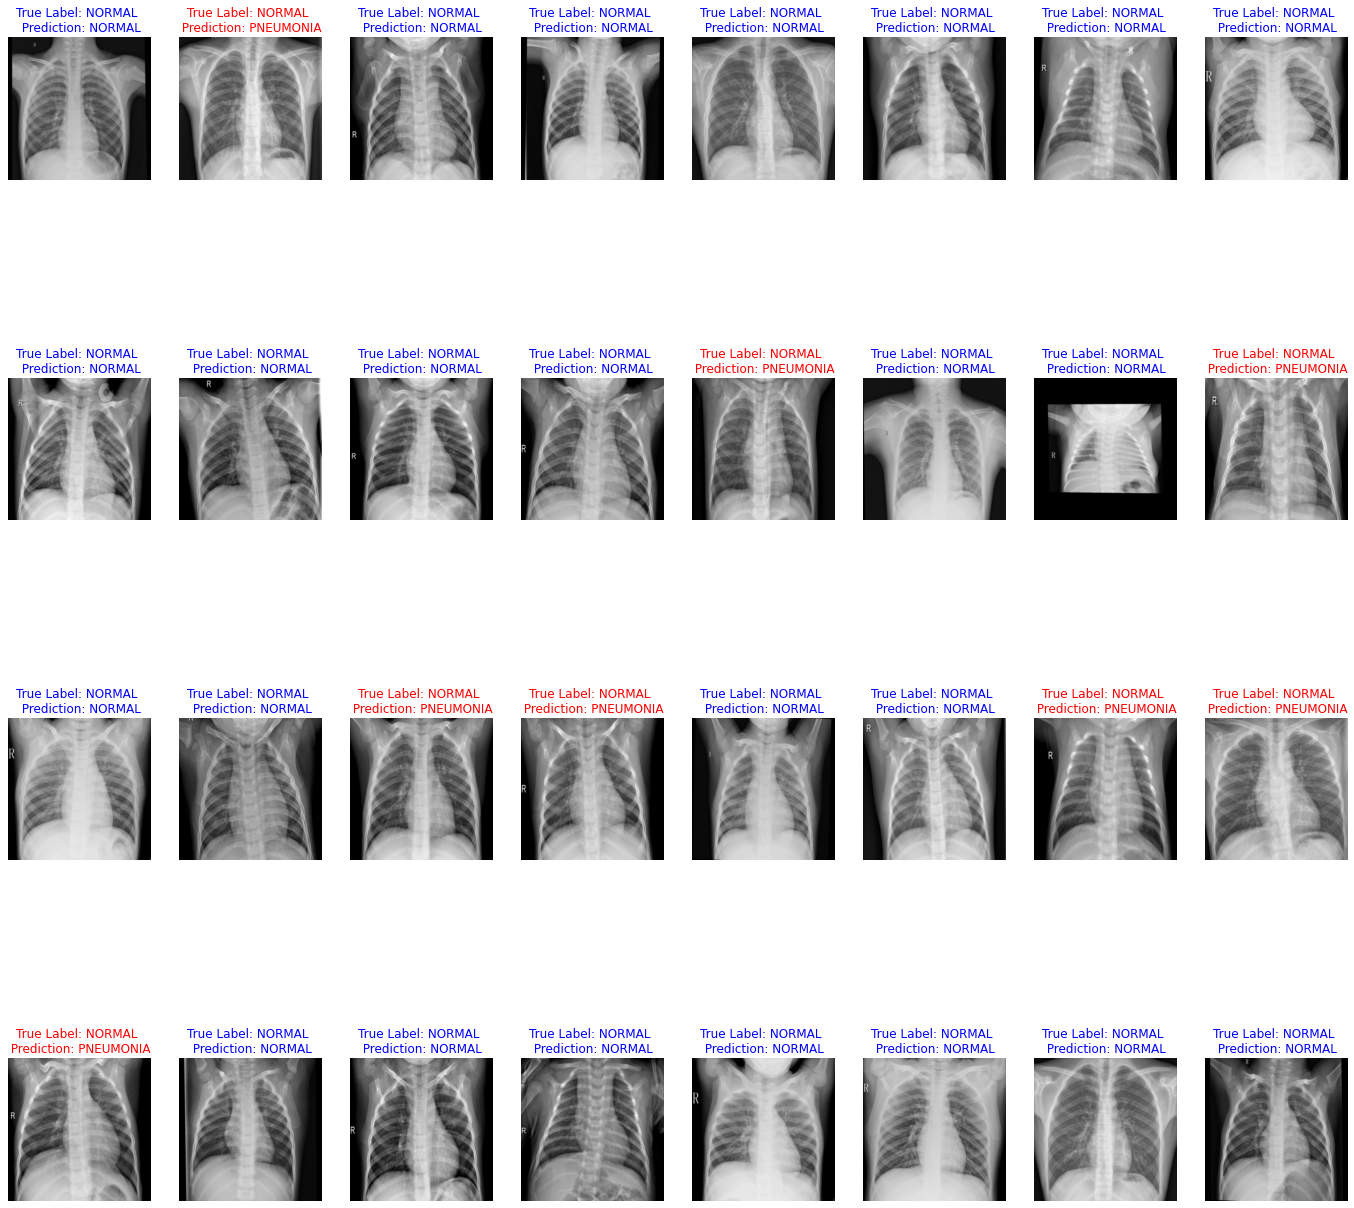

In [ ]:
# Predict and visualize using test_dl
predict_and_visualize(best_model, test_dl, labels)

In [ ]:
with torch.no_grad():
  best_model.eval()
  output = best_model(input)
  preds = output.argmax(1)

In [ ]:
label = label.to('cpu')
preds = preds.to('cpu')
print(classification_report(label, preds, target_names=labels))

              precision    recall  f1-score   support

      NORMAL       1.00      0.86      0.92        43
   PNEUMONIA       0.92      1.00      0.96        69

    accuracy                           0.95       112
   macro avg       0.96      0.93      0.94       112
weighted avg       0.95      0.95      0.95       112



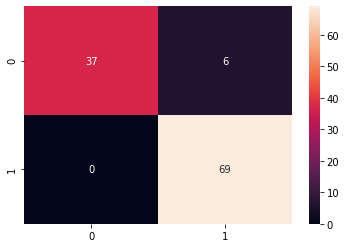

In [ ]:
cf_matrix = confusion_matrix(label, preds)
sns.heatmap(cf_matrix, annot=True)

# Save Model into Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# Save the model
torch.save(best_model, '/content/gdrive/MyDrive/model/PneumoniaNet.pt')

In [ ]:
# Save weight model
torch.save(best_model.state_dict(), '/content/gdrive/MyDrive/model/weight/PneumoniaNet.pth')